In [1]:
from collections import Counter
import glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
from torchvision import transforms
import torchvision.datasets as datasets



print('done')

done


In [2]:
# mnist data reader

transform = transforms.Compose([
    transforms.ToTensor()
])

train_set = datasets.MNIST(root='./', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./', train=False, download=True, transform=transform)

batch_size = 100

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x1177d8780>,
 <torch.utils.data.dataloader.DataLoader at 0x10d934da0>)

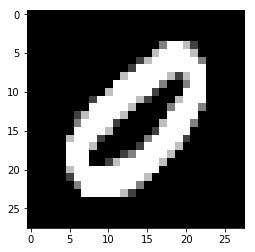

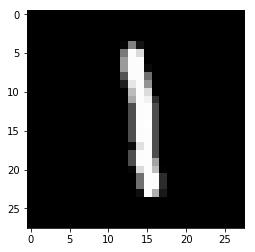

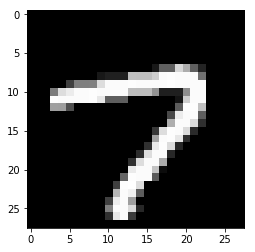

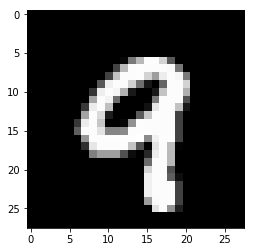

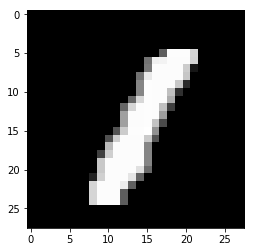

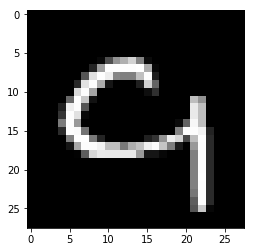

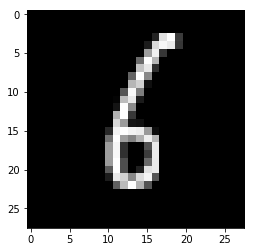

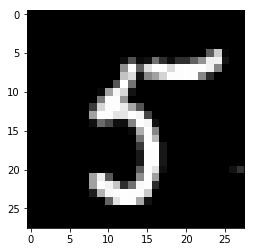

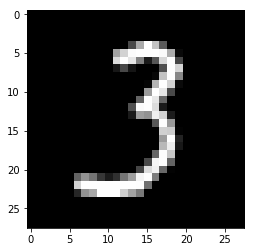

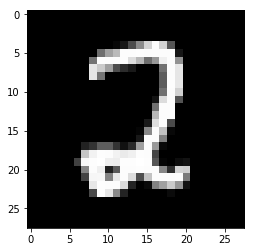

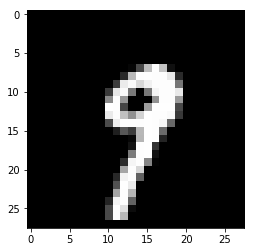

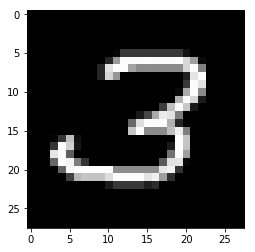

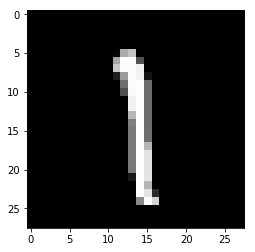

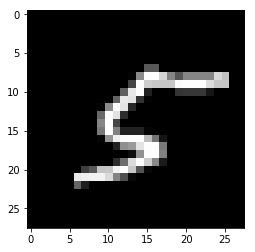

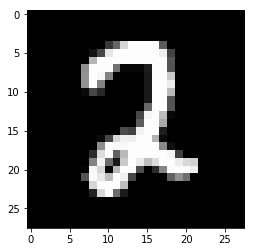

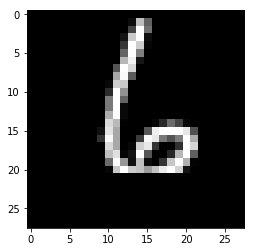

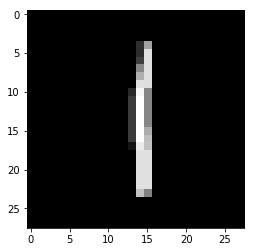

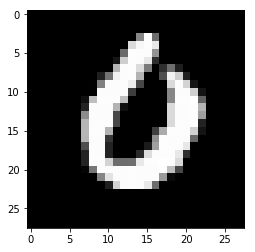

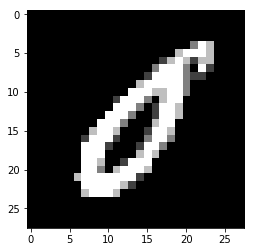

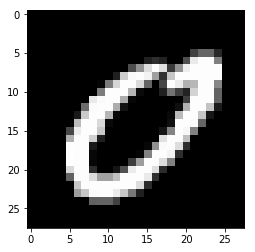

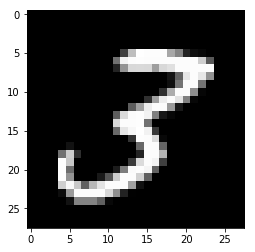

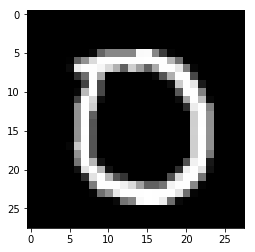

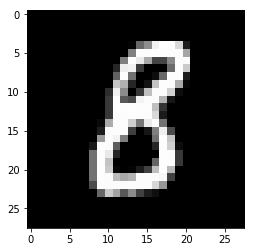

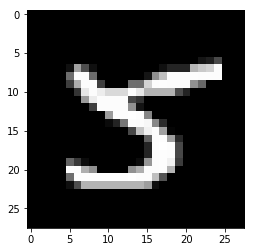

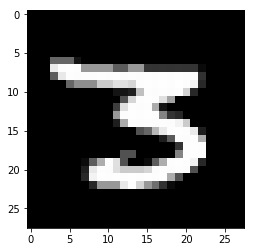

In [3]:
# mnist data reader

def gray_to_rgb(x):
    x = np.array(x[0,:,:]) 
    return torch.tensor(np.stack([x,x,x], axis = -1).reshape((3,28,28)))

normalize = transforms.Normalize((0.1307,), (0.1307,))

transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

train_set = datasets.MNIST(root='./', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./', train=False, download=True, transform=transform)

batch_size = 25

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
train_loader, test_loader

for i, (inputs, outputs) in enumerate(train_loader):
    for image in inputs.numpy():
        image = image.reshape((28,28))
        plt.imshow(image, cmap = 'gray')
        plt.show()
    break

In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,32,3)
        self.conv3 = nn.Conv2d(32,64,3)
        self.fc1 = nn.Linear(64 * 9, 120)
        self.fc2 = nn.Linear(120,120)
        self.encoding = nn.Linear(120,25)
        self.fc3 = nn.Linear(25,10)
        
        
    def forward(self, x):
        x = x.reshape((x.shape[0],1,28,28))
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.relu(self.conv3(x))
        x = x.reshape((x.shape[0], x.shape[1] * x.shape[2] * x.shape[3]))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        encoded = torch.relu(self.encoding(x))
        
        return self.fc3(encoded), encoded
        

    
classifier = Classifier()
classifier(torch.randn((1,1,28,28)))
classifier

Classifier(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=120, bias=True)
  (encoding): Linear(in_features=120, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=10, bias=True)
)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum = 0.9)
print('done')

done


In [7]:
def fit(model, train_loader, metric, optimizer, epochs = 5, log_every = 100):
    for j in range(epochs):
        total = 0
        correct = 0
        losses = []
        for i, (inputs, outputs) in enumerate(train_loader):
            optimizer.zero_grad()
            predictions, encoded = model(inputs)
            loss = metric(predictions, outputs)  
            #loss += 0.0001 * torch.sum(torch.abs(encoded))
            correct += sum(torch.max(predictions, -1)[1] == outputs).item()
            total += predictions.shape[0]
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            if i%log_every == 0:
                print(j, np.mean(losses), correct/total)
                
fit(classifier, train_loader, criterion, optimizer, epochs = 5, log_every = 100)

0 2.3246543407440186 0.08
0 2.1224975208244703 0.2526732673267327
0 1.3994017828311494 0.5188059701492538
0 1.0376180541574758 0.6473089700996678
0 0.8367124986265811 0.7183042394014962
0 0.7057314677435362 0.764311377245509
0 0.6187229810721131 0.7946089850249584
0 0.5527771872484235 0.8172325249643366
0 0.49974779564696603 0.8354057428214732
0 0.45607281002612965 0.8500776914539401
0 0.4208227331686363 0.8620579420579421
0 0.3934319231014819 0.8713896457765667
0 0.3701911946491289 0.8795004163197335
0 0.34898035180907794 0.8866102997694082
0 0.33218506117360325 0.8923625981441827
0 0.31555066532419707 0.8980946035976016
0 0.30169984211423595 0.90263585259213
0 0.2893478361108348 0.9067607289829512
0 0.27946091561244285 0.9101832315380344
0 0.26977821018964226 0.9134560757496055
0 0.259942533136065 0.9165817091454272
0 0.2515208893521225 0.9193717277486911
0 0.24381618237881683 0.9219627442071786
0 0.23582438122624438 0.9245371577574968
1 0.009662246331572533 1.0
1 0.08136295261193473

In [7]:
# Monitor accuracy in test and train 
# Quality monitoring visualizaing incorrect and correct in test and train
# Transfer learning
# Image augmentations
# Visualzaing what conv layers learn
# Visualize what activations learn

def evaluate(model, test_loader):
    correct = 0
    total = 0
    for i, data in enumerate(test_loader):
        inputs, outputs = data
        predictions, encoded = model(inputs)
        predictions = torch.max(predictions, -1)[1]
        correct += sum(predictions == outputs).item()
        total += predictions.shape[0]
    return correct / total
        
        
evaluate(classifier, test_loader)

0.9888

In [ ]:
# find which neurons get activated for a given digit
from collections import defaultdict


def get_activating_neurons(digit, test_loader):
    d = defaultdict(list)
    for inputs, outputs in test_loader:
        predictions, encoded = classifier(inputs)
        for output, rep in zip(outputs, encoded):
            d[output.item()].append(rep.detach().numpy())
    d[digit] = np.array(d[digit])
    d[digit] = np.mean(d[digit], axis = 0)
    plt.figure(figsize=(10,5))
    plt.bar(range(0,25), d[digit])
    plt.xticks(range(0,25))
    plt.show()
        

for i in range(0,10):
    print('activating neurons for digit ', i)
    get_activating_neurons(i, test_loader)

In [ ]:
### find digits which activate a neuron


def get_activating_digit(dim_number, test_loader):
    d = defaultdict(lambda : 0)
    for inputs, outputs in test_loader:
        predictions, encoded = classifier(inputs)
        for output, rep in zip(outputs, encoded):
            d[output.item()] += rep.detach().numpy()[dim_number]
    d = sorted(d.items())        
    x = [ e[0] for e in d ]
    y = [ e[1] for e in d ]
    plt.bar(x, y)
    plt.xticks(range(0,10), range(0,10))
    plt.show()

for i in range(25):
    print("digit activation graph of neuron " + str(i))
    get_activating_digit(i, test_loader)
        
        
    


In [ ]:
# Find what part of image contributes to probability score by occluding image
from collections import defaultdict

def get_activation_heatmap(digit, test_loader):
    digit_images = None
    d = defaultdict(lambda : 0)
    for inputs, outputs in test_loader:
        for image, output in zip(inputs, outputs):
            if output.item() == digit:
                digit_image = image
    
   
    heat_map = np.zeros((28,28))
    

    digit_image = digit_image.reshape((28,28,1))
    actual_predictions, actual_encoded = classifier(digit_image.reshape((1,28,28,1)))
    

    for i in range(25):
        for j in range(23):
            occluded_image = digit_image.numpy().copy()
            occluded_image[i:i+5,j:j+5] = 0
            occluded_predictions, occluded_encoded = classifier(torch.tensor(occluded_image.reshape((1,28,28,1))))
            difference = 255 * abs(actual_predictions[0][1].item() - occluded_predictions[0][1].item())
            heat_map[i:i+5,j:j+5] = difference
        
    
    
    plt.figure(figsize=(3,3))
    plt.imshow(digit_image.reshape((28,28)), cmap = 'gray')
    plt.show()
    plt.figure(figsize=(3,3))
    plt.imshow(heat_map, cmap = 'gray')
    plt.show()
        
       

            
print('ACTIVATION IMAGES AND HEATMAPS')      

for digit in range(10):
    get_activation_heatmap(digit, test_loader) 

In [ ]:
# Find what part of image contributes to probability score by occluding image


def get_activating_patch(dim_number, test_loader):
    max_activation = 0
    activating_patch = None
    k = 0
    for inputs, outputs in test_loader:
        k += 1
        for image, output in zip(inputs, outputs):
            un_image =  image.numpy()[0].copy() * 0.137 + 0.137
            n_image = image.numpy()[0].copy()

            for i in range(25):
                for j in range(25):
                    un_patch = np.zeros((28,28))
                    patch = np.zeros((28,28))
                    un_patch[i:i+3][j:j+3] = un_image.copy()[i:i+3][j:j+3]
                    patch[i:i+3][j:j+3] = n_image.copy()[i:i+3][j:j+3]
                    predictions, encoded = classifier(torch.tensor(patch, dtype = torch.float32).reshape((1,1,28,28)))
                    if abs(encoded[0][dim_number].item()) > max_activation:
                        max_activation = encoded[0][dim_number].item()
                        activating_patch = un_patch.copy()
        if k>=10:
            break
              
    if activating_patch:
        plt.imshow(activating_patch, cmap = 'gray')         
        plt.show() 
            

                        
                    
                    
    
for i in range(25):
    print('ACTIVATION PATCH FOR NEURON ', i)
    get_activating_patch(i, test_loader)
    

### localization is a natural result of classification

### Generate image given class

In [8]:
for param in classifier.parameters():
    param.requires_grad = False

0 0.44721072912216187 tensor(-0.4472, requires_grad=True)
1000 -444.8855895996094 tensor(444.8856, requires_grad=True)
2000 -948.3573608398438 tensor(948.3574, requires_grad=True)
3000 -1455.3675537109375 tensor(1455.3676, requires_grad=True)
4000 -1962.5267333984375 tensor(1962.5267, requires_grad=True)
5000 -2470.70849609375 tensor(2470.7085, requires_grad=True)
6000 -2980.343505859375 tensor(2980.3435, requires_grad=True)
7000 -3491.582763671875 tensor(3491.5828, requires_grad=True)
8000 -4010.482421875 tensor(4010.4824, requires_grad=True)
9000 -4526.91552734375 tensor(4526.9155, requires_grad=True)
10000 -5042.87890625 tensor(5042.8789, requires_grad=True)
11000 -5558.689453125 tensor(5558.6895, requires_grad=True)
12000 -6074.572265625 tensor(6074.5723, requires_grad=True)
13000 -6591.35498046875 tensor(6591.3550, requires_grad=True)
14000 -7107.93310546875 tensor(7107.9331, requires_grad=True)
15000 -7624.53369140625 tensor(7624.5337, requires_grad=True)
16000 -8141.67578125 ten

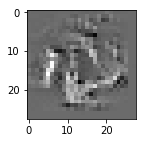

0 -0.5044565200805664 tensor(0.5045, requires_grad=True)
1000 -119.9377670288086 tensor(119.9378, requires_grad=True)
2000 -262.3865966796875 tensor(262.3866, requires_grad=True)
3000 -406.15338134765625 tensor(406.1534, requires_grad=True)
4000 -552.1012573242188 tensor(552.1013, requires_grad=True)
5000 -697.5986938476562 tensor(697.5987, requires_grad=True)
6000 -842.9393310546875 tensor(842.9393, requires_grad=True)
7000 -988.24462890625 tensor(988.2446, requires_grad=True)
8000 -1133.6102294921875 tensor(1133.6102, requires_grad=True)
9000 -1278.92529296875 tensor(1278.9253, requires_grad=True)
10000 -1424.295166015625 tensor(1424.2952, requires_grad=True)
11000 -1569.7137451171875 tensor(1569.7137, requires_grad=True)
12000 -1715.1265869140625 tensor(1715.1266, requires_grad=True)
13000 -1860.5709228515625 tensor(1860.5709, requires_grad=True)
14000 -2006.116455078125 tensor(2006.1165, requires_grad=True)
15000 -2151.720703125 tensor(2151.7207, requires_grad=True)
16000 -2297.282

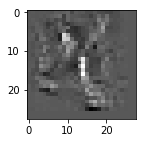

0 0.07923019677400589 tensor(-0.0792, requires_grad=True)
1000 -625.2649536132812 tensor(625.2650, requires_grad=True)
2000 -1286.1815185546875 tensor(1286.1815, requires_grad=True)
3000 -1969.0296630859375 tensor(1969.0297, requires_grad=True)
4000 -2649.689453125 tensor(2649.6895, requires_grad=True)
5000 -3333.359619140625 tensor(3333.3596, requires_grad=True)
6000 -4017.9765625 tensor(4017.9766, requires_grad=True)
7000 -4702.78955078125 tensor(4702.7896, requires_grad=True)
8000 -5387.41064453125 tensor(5387.4106, requires_grad=True)
9000 -6071.830078125 tensor(6071.8301, requires_grad=True)
10000 -6757.3408203125 tensor(6757.3408, requires_grad=True)
11000 -7443.65771484375 tensor(7443.6577, requires_grad=True)
12000 -8129.8330078125 tensor(8129.8330, requires_grad=True)
13000 -8816.0498046875 tensor(8816.0498, requires_grad=True)
14000 -9502.224609375 tensor(9502.2246, requires_grad=True)
15000 -10188.365234375 tensor(10188.3652, requires_grad=True)
16000 -10874.677734375 tensor

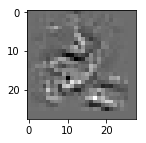

0 0.10924236476421356 tensor(-0.1092, requires_grad=True)
1000 -631.4097290039062 tensor(631.4097, requires_grad=True)
2000 -1347.88232421875 tensor(1347.8823, requires_grad=True)
3000 -2072.071533203125 tensor(2072.0715, requires_grad=True)
4000 -2799.597412109375 tensor(2799.5974, requires_grad=True)
5000 -3529.637939453125 tensor(3529.6379, requires_grad=True)
6000 -4261.822265625 tensor(4261.8223, requires_grad=True)
7000 -4994.42724609375 tensor(4994.4272, requires_grad=True)
8000 -5726.3623046875 tensor(5726.3623, requires_grad=True)
9000 -6458.212890625 tensor(6458.2129, requires_grad=True)
10000 -7190.01171875 tensor(7190.0117, requires_grad=True)
11000 -7922.24267578125 tensor(7922.2427, requires_grad=True)
12000 -8654.3798828125 tensor(8654.3799, requires_grad=True)
13000 -9386.404296875 tensor(9386.4043, requires_grad=True)
14000 -10118.396484375 tensor(10118.3965, requires_grad=True)
15000 -10850.50390625 tensor(10850.5039, requires_grad=True)
16000 -11582.80078125 tensor(1

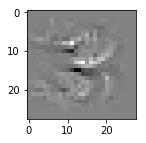

0 0.16680866479873657 tensor(-0.1668, requires_grad=True)
1000 -610.7302856445312 tensor(610.7303, requires_grad=True)
2000 -1276.3802490234375 tensor(1276.3802, requires_grad=True)
3000 -1960.529296875 tensor(1960.5293, requires_grad=True)
4000 -2644.49755859375 tensor(2644.4976, requires_grad=True)
5000 -3328.11962890625 tensor(3328.1196, requires_grad=True)
6000 -4015.21826171875 tensor(4015.2183, requires_grad=True)
7000 -4704.5146484375 tensor(4704.5146, requires_grad=True)
8000 -5396.62841796875 tensor(5396.6284, requires_grad=True)
9000 -6088.84228515625 tensor(6088.8423, requires_grad=True)
10000 -6781.04296875 tensor(6781.0430, requires_grad=True)
11000 -7475.26953125 tensor(7475.2695, requires_grad=True)
12000 -8172.50634765625 tensor(8172.5063, requires_grad=True)
13000 -8872.6181640625 tensor(8872.6182, requires_grad=True)
14000 -9571.97265625 tensor(9571.9727, requires_grad=True)
15000 -10269.921875 tensor(10269.9219, requires_grad=True)
16000 -10967.3173828125 tensor(1096

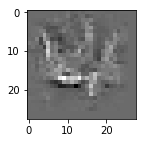

0 0.11512000113725662 tensor(-0.1151, requires_grad=True)
1000 -222.43243408203125 tensor(222.4324, requires_grad=True)
2000 -457.749267578125 tensor(457.7493, requires_grad=True)
3000 -698.4873657226562 tensor(698.4874, requires_grad=True)
4000 -946.2157592773438 tensor(946.2158, requires_grad=True)
5000 -1194.482666015625 tensor(1194.4827, requires_grad=True)
6000 -1444.71923828125 tensor(1444.7192, requires_grad=True)
7000 -1701.1654052734375 tensor(1701.1654, requires_grad=True)
8000 -1956.7882080078125 tensor(1956.7882, requires_grad=True)
9000 -2212.576904296875 tensor(2212.5769, requires_grad=True)
10000 -2469.2900390625 tensor(2469.2900, requires_grad=True)
11000 -2726.267822265625 tensor(2726.2678, requires_grad=True)
12000 -2982.810546875 tensor(2982.8105, requires_grad=True)
13000 -3239.15087890625 tensor(3239.1509, requires_grad=True)
14000 -3495.573486328125 tensor(3495.5735, requires_grad=True)
15000 -3752.0654296875 tensor(3752.0654, requires_grad=True)
16000 -4008.61718

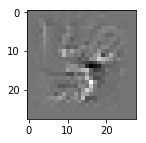

0 0.6806715130805969 tensor(-0.6807, requires_grad=True)
1000 -425.5833740234375 tensor(425.5834, requires_grad=True)
2000 -962.803466796875 tensor(962.8035, requires_grad=True)
3000 -1511.4312744140625 tensor(1511.4313, requires_grad=True)
4000 -2059.55908203125 tensor(2059.5591, requires_grad=True)
5000 -2609.10302734375 tensor(2609.1030, requires_grad=True)
6000 -3162.71728515625 tensor(3162.7173, requires_grad=True)
7000 -3719.747802734375 tensor(3719.7478, requires_grad=True)
8000 -4280.005859375 tensor(4280.0059, requires_grad=True)
9000 -4842.431640625 tensor(4842.4316, requires_grad=True)
10000 -5407.0107421875 tensor(5407.0107, requires_grad=True)
11000 -5975.87548828125 tensor(5975.8755, requires_grad=True)
12000 -6546.8896484375 tensor(6546.8896, requires_grad=True)
13000 -7120.392578125 tensor(7120.3926, requires_grad=True)
14000 -7693.8818359375 tensor(7693.8818, requires_grad=True)
15000 -8267.6259765625 tensor(8267.6260, requires_grad=True)
16000 -8842.2080078125 tensor(

KeyboardInterrupt: 

In [33]:

def generate_most_confident_image(digit):
    x = torch.randn((1,1,28,28), requires_grad = True)
    lr = 1
    for i in range(50000):
        predictions, encoded = classifier(x)
        loss = -predictions[0][digit]
        loss.backward()
        with torch.no_grad():
            x -= lr * x.grad
            x.grad.zero_()
            if i % 1000 == 0:
                print(i, loss.item(), predictions[0][digit])

    x = x.detach().numpy()
    x = x.reshape((28,28))
    plt.figure(figsize=(2,2))
    plt.imshow(x, cmap = 'gray')
    plt.show()

    return torch.softmax(classifier(torch.tensor(x).reshape(1,1,28,28))[0][0], dim = 0)

for i in range(10):
    generate_most_confident_image(i)

original image and target


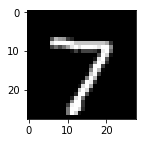

tensor(7)
0 tensor(nan, grad_fn=<NegBackward>) tensor(nan, requires_grad=True) tensor(0)


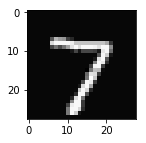

2000 tensor(nan, grad_fn=<NegBackward>) tensor(nan, requires_grad=True) tensor(0)


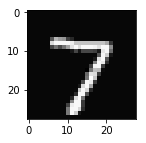

4000 tensor(nan, grad_fn=<NegBackward>) tensor(nan, requires_grad=True) tensor(0)


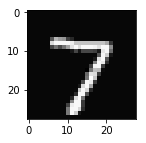

6000 tensor(nan, grad_fn=<NegBackward>) tensor(nan, requires_grad=True) tensor(0)


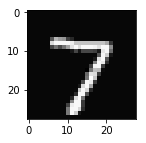

8000 tensor(nan, grad_fn=<NegBackward>) tensor(nan, requires_grad=True) tensor(0)


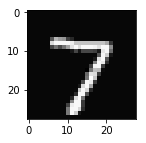

KeyboardInterrupt: 

In [83]:
from sklearn import preprocessing

def do_one_row_attack(image, original_digit, new_digit):
    x = torch.randn(28,28, requires_grad = True)
    with torch.no_grad():
        mask = torch.zeros((28,28))
        mask[15:18,15:18] = 1

    image.requires_grad = False
    lr = 0.001
    for i in range(50000):
        noise = x * mask
        noise = 0.13 * ((noise - noise.mean())/ (0.0001 + noise.std())) + 0.13
        combined_image = image + noise
        combined_image = combined_image.reshape((1,1,28,28))
        predictions, encoded = classifier(combined_image)
        loss = -predictions[0][new_digit] 
        loss.backward()
        with torch.no_grad():
            x -= lr * x.grad
            x.grad.zero_()
            if i % 2000 == 0:
                print(i, loss, predictions[0][new_digit], predictions[0].argmax())
                numpy_image = combined_image.detach().numpy().reshape((28,28))
                plt.figure(figsize=(2,2))
                plt.imshow(numpy_image, cmap = 'gray')
                plt.show()
      
    
      
image = None
original_digit = None
new_digit = 0
for inputs, outputs in test_loader:
    image = inputs[0][0]
    original_digit = outputs[0]
    break

print('original image and target')
plt.figure(figsize=(2,2))
plt.imshow(image.reshape((28,28)), cmap = 'gray')
plt.show()
print(original_digit)
do_one_row_attack(image, original_digit, new_digit)

In [44]:
c = torch.randn(10,5)
c.std()

tensor(1.1284)